In [1]:
import os
import re
import glob



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

from scipy.signal import welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from scipy.signal import welch
from scipy.stats import entropy
from scipy.stats import trim_mean, kurtosis
from scipy.stats import iqr


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, matthews_corrcoef, cohen_kappa_score


In [2]:

# Load the dataset
combined_df = pd.read_csv('C:/Users/DELL G7/Pictures/Camera Roll/projects/newdepression/combined_data.csv')

In [3]:
std_data = combined_df.copy()

In [4]:
# Standardize the 'activity' column
mean_activity = std_data['activity'].mean()
std_activity = std_data['activity'].std()
std_data['activity_standardized'] = (std_data['activity'] - mean_activity) / std_activity


std_data = std_data.drop('activity', axis=1)
std_data.head()

,timestamp,status,person,activity_standardized
0,2003-03-18 15:00:00,nondepressed,control_1,-0.332381
1,2003-03-18 15:01:00,nondepressed,control_1,-0.499176
2,2003-03-18 15:02:00,nondepressed,control_1,0.234721
3,2003-03-18 15:03:00,nondepressed,control_1,1.341127
4,2003-03-18 15:04:00,nondepressed,control_1,0.315339


In [5]:
# Convert the 'timestamp' column to datetime format
std_data['timestamp'] = pd.to_datetime(std_data['timestamp'])

# Round the 'timestamp' column to the nearest hour
std_data['hourly_timestamp'] = std_data['timestamp'].dt.floor('H')

# Group by 'person' and 'hourly_timestamp' and aggregate activity data
hourly_data = std_data.groupby(['person', 'hourly_timestamp', 'status'])['activity_standardized'].agg(
    ['sum', 'mean', 'std', 'skew', 'min', 'max']
).reset_index()

hourly_data.head()


,person,hourly_timestamp,status,sum,mean,std,skew,min,max
0,condition_1,2003-05-07 12:00:00,depressed,27.852200,0.464203,0.722576,1.046916,-0.499176,2.895099
1,condition_1,2003-05-07 13:00:00,depressed,17.513699,0.291895,0.649448,0.965757,-0.499176,2.136183
2,condition_1,2003-05-07 14:00:00,depressed,16.615786,0.276930,0.756995,1.231372,-0.499176,2.686606
3,condition_1,2003-05-07 15:00:00,depressed,6.541377,0.109023,0.829422,2.672737,-0.499176,3.865289
4,condition_1,2003-05-07 16:00:00,depressed,9.838355,0.163973,0.747972,1.665956,-0.499176,2.786683


In [6]:
def extract_frequency_features_adjusted(values, fs=32):
    # Compute the power spectral density using Welch's method with adjusted nperseg
    frequencies, psd_values = welch(values, fs=fs, nperseg=min(60, len(values)))
    
    fundamental_frequency = frequencies[np.argmax(psd_values)]
    
    # Define the frequency bands
    low_band = [0, 0.1]
    mid_band = [0.1, 0.5]
    high_band = [0.5, fs/2]  # Nyquist frequency
    
    low_band_power = np.sum(psd_values[(frequencies >= low_band[0]) & (frequencies < low_band[1])])
    mid_band_power = np.sum(psd_values[(frequencies >= mid_band[0]) & (frequencies < mid_band[1])])
    high_band_power = np.sum(psd_values[(frequencies >= high_band[0]) & (frequencies <= high_band[1])])
    

    peak_frequency = frequencies[np.argmax(psd_values)]
    
    return pd.Series({
        'Fundamental Frequency': fundamental_frequency,
        'Low Band Power': low_band_power,
        'Mid Band Power': mid_band_power,
        'High Band Power': high_band_power,
        'Peak Frequency': peak_frequency
    })


In [7]:
# Extract frequency-domain features with adjusted nperseg
frequency_features = std_data.groupby(['person', 'hourly_timestamp']).apply(lambda x: extract_frequency_features_adjusted(x['activity_standardized'])).reset_index()


# Merge the time-domain and adjusted frequency-domain features
merged_features = pd.merge(hourly_data, frequency_features, on=['person', 'hourly_timestamp'])

merged_features.head()

,person,hourly_timestamp,status,sum,mean,std,skew,min,max,Fundamental Frequency,Low Band Power,Mid Band Power,High Band Power,Peak Frequency
0,condition_1,2003-05-07 12:00:00,depressed,27.852200,0.464203,0.722576,1.046916,-0.499176,2.895099,2.666667,0.007132,0.0,1.054531,2.666667
1,condition_1,2003-05-07 13:00:00,depressed,17.513699,0.291895,0.649448,0.965757,-0.499176,2.136183,0.533333,0.000085,0.0,0.523059,0.533333
2,condition_1,2003-05-07 14:00:00,depressed,16.615786,0.276930,0.756995,1.231372,-0.499176,2.686606,5.333333,0.005905,0.0,1.307553,5.333333
3,condition_1,2003-05-07 15:00:00,depressed,6.541377,0.109023,0.829422,2.672737,-0.499176,3.865289,0.533333,0.022422,0.0,1.274211,0.533333
4,condition_1,2003-05-07 16:00:00,depressed,9.838355,0.163973,0.747972,1.665956,-0.499176,2.786683,1.600000,0.008082,0.0,0.565398,1.600000


In [8]:
# Count the number of unique values in a specific column
unique_count_column_b = merged_features['person'].nunique()
print(unique_count_column_b)


55


In [9]:
# 1) Number of observations (rows) per unique person
observations_per_person = merged_features.groupby('person').size()


print(observations_per_person)


person
condition_1      388
condition_10     360
condition_11     384
condition_12     370
condition_13     432
condition_14     362
condition_15     364
condition_16     698
condition_17     360
condition_18     357
condition_19     355
condition_2      649
condition_20     432
condition_21     343
condition_22     364
condition_23     525
condition_3      361
condition_4      361
condition_5      359
condition_6      358
condition_7      370
condition_8      322
condition_9      340
control_1        861
control_10       361
control_11       413
control_12       578
control_13       371
control_14       371
control_15       372
control_16       410
control_17       482
control_18       411
control_19       461
control_2        525
control_20       532
control_21       533
control_22       362
control_23       362
control_24       364
control_25       364
control_26       557
control_27       342
control_28       409
control_29       408
control_3       1091
control_30       362
contro

In [10]:
import pandas as pd

# Assuming you have already defined the merged_features DataFrame

# Calculate the total number of rows
total_rows = len(merged_features)

# Calculate the number of unique persons
unique_persons = merged_features['person'].nunique()

# Calculate the average number of rows per unique person
average_rows_per_person = total_rows / unique_persons

print("Average Rows per Unique Person:", average_rows_per_person)


Average Rows per Unique Person: 476.90909090909093


In [11]:
# Set the target observation count
target_count = 478

# Trim data for individuals with observations above the target count
trimmed_data_list = []
for person, count in observations_per_person.items():
    person_data = merged_features[merged_features['person'] == person]
    if count > target_count:
        person_data = person_data.sample(n=target_count, random_state=42)
    trimmed_data_list.append(person_data)

trimmed_df = pd.concat(trimmed_data_list)
trimmed_df

,person,hourly_timestamp,status,sum,mean,std,skew,min,max,Fundamental Frequency,Low Band Power,Mid Band Power,High Band Power,Peak Frequency
0,condition_1,2003-05-07 12:00:00,depressed,27.852200,0.464203,0.722576,1.046916,-0.499176,2.895099,2.666667,0.007132,0.0,1.054531,2.666667
1,condition_1,2003-05-07 13:00:00,depressed,17.513699,0.291895,0.649448,0.965757,-0.499176,2.136183,0.533333,0.000085,0.0,0.523059,0.533333
2,condition_1,2003-05-07 14:00:00,depressed,16.615786,0.276930,0.756995,1.231372,-0.499176,2.686606,5.333333,0.005905,0.0,1.307553,5.333333
3,condition_1,2003-05-07 15:00:00,depressed,6.541377,0.109023,0.829422,2.672737,-0.499176,3.865289,0.533333,0.022422,0.0,1.274211,0.533333
4,condition_1,2003-05-07 16:00:00,depressed,9.838355,0.163973,0.747972,1.665956,-0.499176,2.786683,1.600000,0.008082,0.0,0.565398,1.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26212,control_9,2003-11-30 19:00:00,nondepressed,-28.782994,-0.479717,0.000000,0.000000,-0.479717,-0.479717,0.000000,0.000000,0.0,0.000000,0.000000
25867,control_9,2003-11-16 10:00:00,nondepressed,-29.475193,-0.491253,0.043123,5.826861,-0.499176,-0.210065,3.733333,0.000019,0.0,0.006046,3.733333
26229,control_9,2003-12-01 12:00:00,nondepressed,-27.617848,-0.476170,0.037165,6.780410,-0.485276,-0.210065,0.551724,0.000015,0.0,0.000504,0.551724
25766,control_9,2003-11-12 05:00:00,nondepressed,-28.782994,-0.479717,0.000000,0.000000,-0.479717,-0.479717,0.000000,0.000000,0.0,0.000000,0.000000


In [12]:
# Bootstrap data for individuals with observations below the target count
bootstrapped_data_list = []
for person, count in observations_per_person.items():
    person_data = trimmed_df[trimmed_df['person'] == person]
    if count < target_count:
        bootstrap_sample = person_data.sample(n=target_count - count, replace=True, random_state=42)
        person_data = pd.concat([person_data, bootstrap_sample])
    bootstrapped_data_list.append(person_data)

balanced_trimmed_df = pd.concat(bootstrapped_data_list)
balanced_trimmed_df

,person,hourly_timestamp,status,sum,mean,std,skew,min,max,Fundamental Frequency,Low Band Power,Mid Band Power,High Band Power,Peak Frequency
0,condition_1,2003-05-07 12:00:00,depressed,27.852200,0.464203,0.722576,1.046916,-0.499176,2.895099,2.666667,0.007132,0.0,1.054531,2.666667
1,condition_1,2003-05-07 13:00:00,depressed,17.513699,0.291895,0.649448,0.965757,-0.499176,2.136183,0.533333,0.000085,0.0,0.523059,0.533333
2,condition_1,2003-05-07 14:00:00,depressed,16.615786,0.276930,0.756995,1.231372,-0.499176,2.686606,5.333333,0.005905,0.0,1.307553,5.333333
3,condition_1,2003-05-07 15:00:00,depressed,6.541377,0.109023,0.829422,2.672737,-0.499176,3.865289,0.533333,0.022422,0.0,1.274211,0.533333
4,condition_1,2003-05-07 16:00:00,depressed,9.838355,0.163973,0.747972,1.665956,-0.499176,2.786683,1.600000,0.008082,0.0,0.565398,1.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26212,control_9,2003-11-30 19:00:00,nondepressed,-28.782994,-0.479717,0.000000,0.000000,-0.479717,-0.479717,0.000000,0.000000,0.0,0.000000,0.000000
25867,control_9,2003-11-16 10:00:00,nondepressed,-29.475193,-0.491253,0.043123,5.826861,-0.499176,-0.210065,3.733333,0.000019,0.0,0.006046,3.733333
26229,control_9,2003-12-01 12:00:00,nondepressed,-27.617848,-0.476170,0.037165,6.780410,-0.485276,-0.210065,0.551724,0.000015,0.0,0.000504,0.551724
25766,control_9,2003-11-12 05:00:00,nondepressed,-28.782994,-0.479717,0.000000,0.000000,-0.479717,-0.479717,0.000000,0.000000,0.0,0.000000,0.000000


In [13]:
# Count the number of unique values in a specific column
unique_count_column_b = balanced_trimmed_df['person'].nunique()
print(unique_count_column_b)


55


In [14]:
# Distribution of data for each unique person
distribution_per_person = balanced_trimmed_df.groupby('person').size()

# Total number of observations in each group
condition_group_count = balanced_trimmed_df[balanced_trimmed_df['person'].str.startswith('condition')].shape[0]
control_group_count = balanced_trimmed_df[balanced_trimmed_df['person'].str.startswith('control')].shape[0]

distribution_per_person


person
condition_1     478
condition_10    478
condition_11    478
condition_12    478
condition_13    478
condition_14    478
condition_15    478
condition_16    478
condition_17    478
condition_18    478
condition_19    478
condition_2     478
condition_20    478
condition_21    478
condition_22    478
condition_23    478
condition_3     478
condition_4     478
condition_5     478
condition_6     478
condition_7     478
condition_8     478
condition_9     478
control_1       478
control_10      478
control_11      478
control_12      478
control_13      478
control_14      478
control_15      478
control_16      478
control_17      478
control_18      478
control_19      478
control_2       478
control_20      478
control_21      478
control_22      478
control_23      478
control_24      478
control_25      478
control_26      478
control_27      478
control_28      478
control_29      478
control_3       478
control_30      478
control_31      478
control_32      478
control_4    

In [15]:
# Split the data into features and target
X_data = balanced_trimmed_df.drop(columns=['person','hourly_timestamp', 'status', ])
y_data = balanced_trimmed_df['status']


In [16]:
import numpy as np

# Check for NaN values
nan_values = X_data.isna().sum()

# Check for inf values
inf_values = np.isinf(X_data).sum()

print("Number of NaN values in each column:")
print(nan_values)

print("\nNumber of inf values in each column:")
print(inf_values)


Number of NaN values in each column:
sum                      0
mean                     0
std                      1
skew                     2
min                      0
max                      0
Fundamental Frequency    0
Low Band Power           0
Mid Band Power           0
High Band Power          0
Peak Frequency           0
dtype: int64

Number of inf values in each column:
sum                      0
mean                     0
std                      0
skew                     0
min                      0
max                      0
Fundamental Frequency    0
Low Band Power           0
Mid Band Power           0
High Band Power          0
Peak Frequency           0
dtype: int64


In [17]:
# Replace NaN values with the median of the respective columns
X_data = X_data.fillna(X_data.median())

# RANDOM FOREST WITH PERSON BASED LOOCV

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

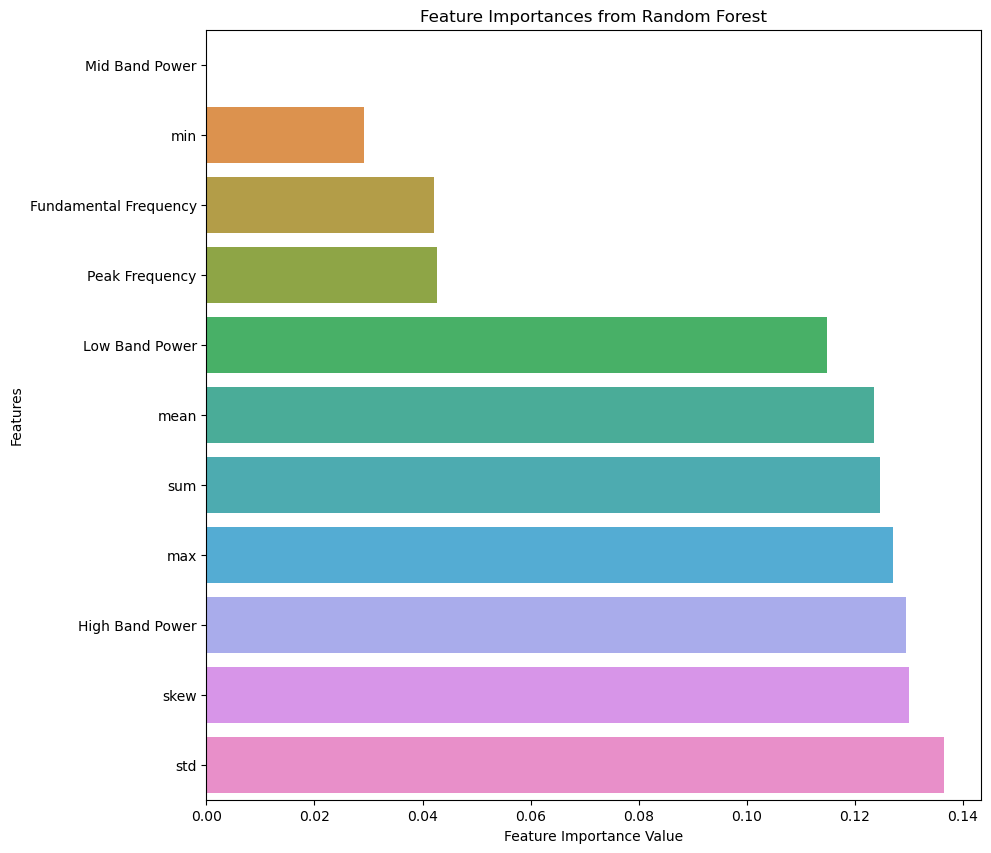

In [20]:

rf.fit(X_data, y_data)

# Extract feature importances
feature_importances = rf.feature_importances_

# Sort features based on importance
sorted_idx = feature_importances.argsort()

# Plot
plt.figure(figsize=(10, 10))
plt.title('Feature Importances from Random Forest')
sns.barplot(x=feature_importances[sorted_idx], y=X_data.columns[sorted_idx])
plt.xlabel('Feature Importance Value')
plt.ylabel('Features')
plt.show()

In [21]:
# Select important features based on a threshold
threshold = 0.10
important_features = X_data.columns[feature_importances > threshold]
important_features

Index(['sum', 'mean', 'std', 'skew', 'max', 'Low Band Power',
       'High Band Power'],
      dtype='object')

In [22]:
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameter grid
param_dist = {
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use RandomizedSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=100, cv=3, verbose=1, random_state=42, n_jobs=1)
random_search.fit(X_data[important_features], y_data)

# Get the best parameters
best_params = random_search.best_params_

best_params

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': True}

In [23]:
# Lists to store evaluation metrics
tnew_accuracies = []
tnew_classification_reports = []
tnew_mcc_scores = []
tnew_kappa_scores = []
tnew_confusion_matrices = []

# Initialize the Random Forest Classifier with the best parameters
rf_best = RandomForestClassifier(**best_params, random_state=42)

# Extract unique persons
persons = balanced_trimmed_df['person'].unique()

# Dictionary to store predictions for each person
tnew_predictions_dict = {}


# Create a list to store X_test data for each individual
combined_X_test_list = []


# LOOCV based on persons
for person in persons:
    # Split the data into train and test based on the current person in the loop
    X_train = X_data[balanced_trimmed_df['person'] != person][important_features]
    y_train = balanced_trimmed_df[balanced_trimmed_df['person'] != person]['status']
    X_test = X_data[balanced_trimmed_df['person'] == person][important_features]
    y_test = balanced_trimmed_df[balanced_trimmed_df['person'] == person]['status']
    
    # Inside your LOOCV loop, after defining X_test, add:
    combined_X_test_list.append(X_test)

    
    # Train the model using the best parameters
    rf_best.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = rf_best.predict(X_test)
    
    # Store predictions in the dictionary
    tnew_predictions_dict[person] = y_pred
    
    # Calculate evaluation metrics
    tnew_accuracies.append(accuracy_score(y_test, y_pred))
    tnew_classification_reports.append(classification_report(y_test, y_pred, output_dict=True))
    tnew_mcc_scores.append(matthews_corrcoef(y_test, y_pred))
    tnew_kappa_scores.append(cohen_kappa_score(y_test, y_pred))
    tnew_confusion_matrices.append(confusion_matrix(y_test, y_pred))

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Create lists to store the results
tnewpersons_list = []
tnewcorrect_percentage_list = []
tnewincorrect_percentage_list = []

# Iterate over each person and calculate the percentages
for person, predictions in tnew_predictions_dict.items():
    # Get true labels for the person
    true_labels = balanced_trimmed_df[balanced_trimmed_df['person'] == person]['status'].values
    
    # Calculate the number of correct predictions
    tcorrect_predictions = np.sum(predictions == true_labels)
    
    # Calculate the percentage of correct and incorrect predictions
    total_predictions = len(predictions)
    correct_percentage = (tcorrect_predictions / total_predictions) * 100
    incorrect_percentage = 100 - correct_percentage
    
    # Append to the lists
    tnewpersons_list.append(person)
    tnewcorrect_percentage_list.append(correct_percentage)
    tnewincorrect_percentage_list.append(incorrect_percentage)

# Create a DataFrame from the results
percentage_df = pd.DataFrame({
    'Person': tnewpersons_list,
    'Correct Prediction (%)': tnewcorrect_percentage_list,
    'Incorrect Prediction (%)': tnewincorrect_percentage_list
})

# Display the DataFrame
percentage_df

,Person,Correct Prediction (%),Incorrect Prediction (%)
0,condition_1,43.305439,56.694561
1,condition_10,23.012552,76.987448
2,condition_11,44.979079,55.020921
3,condition_12,46.652720,53.347280
4,condition_13,27.615063,72.384937
5,condition_14,72.384937,27.615063
6,condition_15,48.535565,51.464435
7,condition_16,26.569038,73.430962
8,condition_17,70.920502,29.079498
9,condition_18,80.962343,19.037657


In [25]:
from sklearn.metrics import classification_report

# Lists to store true labels and predictions for each group
tcondition_true_labels = []
tcondition_predicted_labels = []
tcontrol_true_labels = []
tcontrol_predicted_labels = []

# Iterate over each person's predictions in the dictionary
for person, predictions in tnew_predictions_dict.items():
    # Get true labels for the person
    true_labels = balanced_trimmed_df[balanced_trimmed_df['person'] == person]['status'].values
    
    # Append true labels and predictions to the respective lists based on the person's group
    if person.startswith('condition'):
        tcondition_true_labels.extend(true_labels)
        tcondition_predicted_labels.extend(predictions)
    else:
        tcontrol_true_labels.extend(true_labels)
        tcontrol_predicted_labels.extend(predictions)

# Combine true labels and predicted labels from both groups
tcombined_true_labels = tcondition_true_labels + tcontrol_true_labels
tcombined_predicted_labels = tcondition_predicted_labels + tcontrol_predicted_labels

# Generate a single classification report for the combined data
combined_classification_report = classification_report(tcombined_true_labels, tcombined_predicted_labels, output_dict=True, zero_division=1)

# Convert the classification report to a DataFrame for better visualization
combined_report_df = pd.DataFrame(combined_classification_report).transpose()

# Display the combined classification report
combined_report_df


,precision,recall,f1-score,support
depressed,0.533712,0.427688,0.474854,10994.000000
nondepressed,0.640046,0.731433,0.682695,15296.000000
accuracy,0.604412,0.604412,0.604412,0.604412
macro avg,0.586879,0.579560,0.578774,26290.000000
weighted avg,0.595579,0.604412,0.595779,26290.000000


In [26]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

# Calculate MCC and Cohen's Kappa for the combined data
combined_mcc = matthews_corrcoef(tcombined_true_labels, tcombined_predicted_labels)
combined_kappa = cohen_kappa_score(tcombined_true_labels, tcombined_predicted_labels)

combined_mcc, combined_kappa


(0.1662782015639609, 0.1636937832621791)

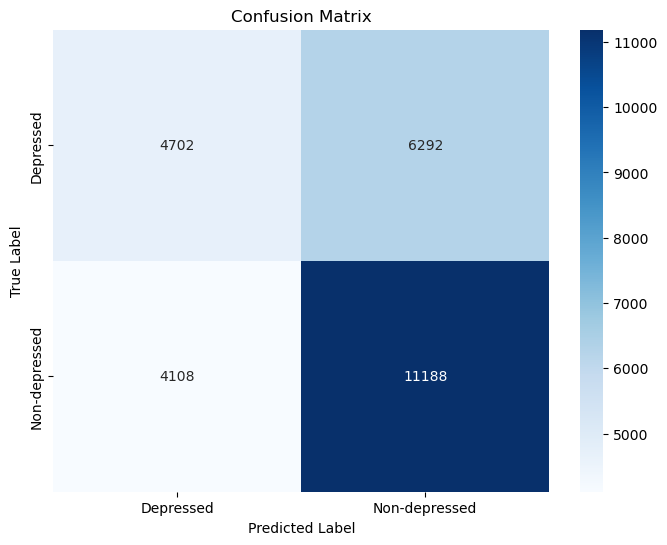

In [27]:
# Calculate the confusion matrix for the combined data
combined_cm = confusion_matrix(tcombined_true_labels, tcombined_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(combined_cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Depressed', 'Non-depressed'],
            yticklabels=['Depressed', 'Non-depressed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



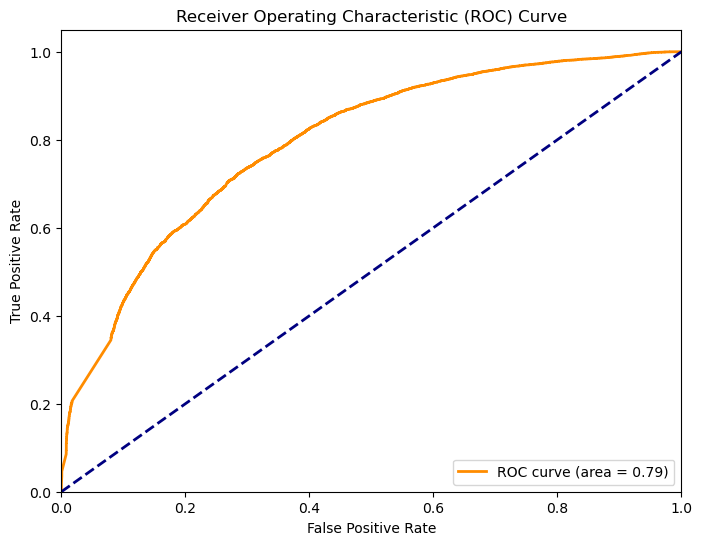

In [28]:
# For the ROC curve:

# After the loop, combine all X_test data
combined_X_test = pd.concat(combined_X_test_list)

# Compute the predicted probabilities using the Random Forest classifier
combined_predicted_probs = rf_best.predict_proba(combined_X_test)[:, 1]

# Compute ROC curve and ROC area for the combined data
fpr, tpr, _ = roc_curve(tcombined_true_labels, combined_predicted_probs, pos_label='nondepressed')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# LOGISTIC REGRESSION

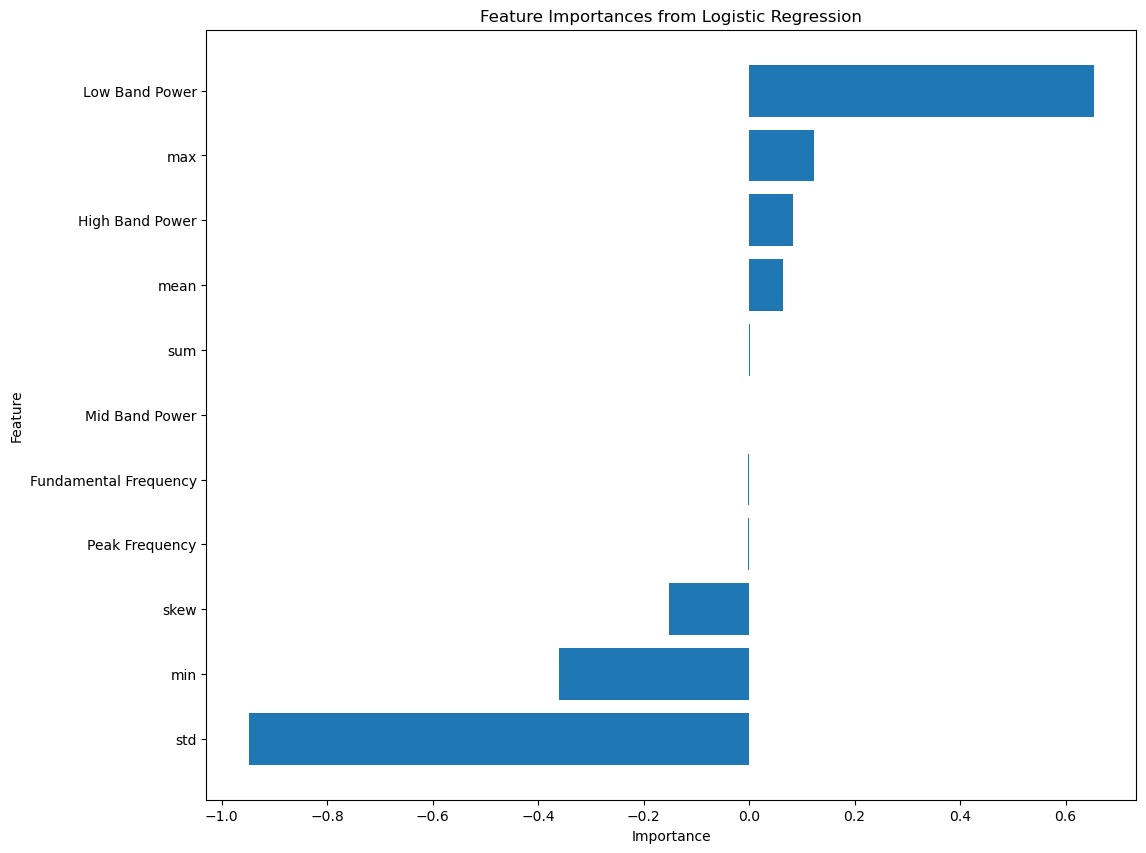

In [29]:
from sklearn.linear_model import LogisticRegression

# Initialize and fit the logistic regression model
logreg = LogisticRegression(max_iter=10000, random_state=42)
logreg.fit(X_data, y_data)

# Extract the coefficients
feature_importances = logreg.coef_[0]

# Create a DataFrame to visualize feature importances
importance_df = pd.DataFrame({
    'Feature': X_data.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Logistic Regression')
plt.gca().invert_yaxis()  # To display the feature with the highest importance at the top
plt.show()

In [30]:
# Set a threshold
threshold = 0.07  # You can adjust this value based on your needs

# Select features where the importance (magnitude of coefficient) is above the threshold
selected_features = importance_df[importance_df['Importance'].abs() > threshold]['Feature'].tolist()

selected_features


['Low Band Power', 'max', 'High Band Power', 'skew', 'min', 'std']

In [31]:
importance_df

,Feature,Importance
7,Low Band Power,0.653954
5,max,0.122959
9,High Band Power,0.082203
1,mean,0.064461
0,sum,0.002576
8,Mid Band Power,0.000000
6,Fundamental Frequency,-0.001903
10,Peak Frequency,-0.001903
3,skew,-0.151386
4,min,-0.360984


In [32]:


# Define the parameters to search
param_dist = {
    'C': np.logspace(-4, 4, 20),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 1000, 5000]
}


# # Initialize Logistic Regression
# log_reg = LogisticRegression()

# Initialize RandomizedSearchCV
log_reg_random_search = RandomizedSearchCV(logreg, param_distributions=param_dist,
                                           n_iter=100, cv=10, verbose=1, random_state=42, n_jobs=1)


log_reg_random_search.fit(X_data[important_features], y_data)

# random_search.fit(tX_data[important_features], ty_data)


# Best parameters
best_params = log_reg_random_search.best_params_

best_params


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\D

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\D

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\D

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\P

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\D

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\P

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\D

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\D

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\D

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\D

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\D

{'solver': 'saga',
 'penalty': 'l1',
 'max_iter': 5000,
 'C': 0.0018329807108324356}

In [34]:
# Lists to store evaluation metrics
lrnew_accuracies = []
lrnew_classification_reports = []
lrnew_mcc_scores = []
lrnew_kappa_scores = []
lrnew_confusion_matrices = []

# Initialize the Random Forest Classifier with the best parameters
lr_best = LogisticRegression(**best_params, random_state=42)

# Extract unique persons
persons = balanced_trimmed_df['person'].unique()

# Dictionary to store predictions for each person
lrnew_predictions_dict = {}

# Create a list to store X_test data for each individual
combined_X_test_list = []


# LOOCV based on persons
for person in persons:
    # Split the data into train and test based on the current person in the loop
    X_train = X_data[balanced_trimmed_df['person'] != person][important_features]
    y_train = balanced_trimmed_df[balanced_trimmed_df['person'] != person]['status']
    X_test = X_data[balanced_trimmed_df['person'] == person][important_features]
    y_test = balanced_trimmed_df[balanced_trimmed_df['person'] == person]['status']
    
    # Inside your LOOCV loop, after defining X_test, add:
    combined_X_test_list.append(X_test)

    
    # Train the model using the best parameters
    lr_best.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = lr_best.predict(X_test)
    
    # Store predictions in the dictionary
    lrnew_predictions_dict[person] = y_pred
    
    # Calculate evaluation metrics
    lrnew_accuracies.append(accuracy_score(y_test, y_pred))
    lrnew_classification_reports.append(classification_report(y_test, y_pred, output_dict=True))
    lrnew_mcc_scores.append(matthews_corrcoef(y_test, y_pred))
    lrnew_kappa_scores.append(cohen_kappa_score(y_test, y_pred))
    lrnew_confusion_matrices.append(confusion_matrix(y_test, y_pred))



C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\Ap

C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL G7\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
# Create lists to store the results
lrnewpersons_list = []
lrnewcorrect_percentage_list = []
lrnewincorrect_percentage_list = []

# Iterate over each person and calculate the percentages
for person, predictions in lrnew_predictions_dict.items():
    # Get true labels for the person
    true_labels = balanced_trimmed_df[balanced_trimmed_df['person'] == person]['status'].values
    
    # Calculate the number of correct predictions
    lrcorrect_predictions = np.sum(predictions == true_labels)
    
    # Calculate the percentage of correct and incorrect predictions
    total_predictions = len(predictions)
    correct_percentage = (lrcorrect_predictions / total_predictions) * 100
    incorrect_percentage = 100 - correct_percentage
    
    # Append to the lists
    lrnewpersons_list.append(person)
    lrnewcorrect_percentage_list.append(correct_percentage)
    lrnewincorrect_percentage_list.append(incorrect_percentage)

# Create a DataFrame from the results
lrpercentage_df = pd.DataFrame({
    'Person': lrnewpersons_list,
    'Correct Prediction (%)': lrnewcorrect_percentage_list,
    'Incorrect Prediction (%)': lrnewincorrect_percentage_list
})

# Display the DataFrame
lrpercentage_df

,Person,Correct Prediction (%),Incorrect Prediction (%)
0,condition_1,16.945607,83.054393
1,condition_10,13.179916,86.820084
2,condition_11,22.384937,77.615063
3,condition_12,11.715481,88.284519
4,condition_13,12.343096,87.656904
5,condition_14,20.502092,79.497908
6,condition_15,18.828452,81.171548
7,condition_16,20.920502,79.079498
8,condition_17,15.899582,84.100418
9,condition_18,8.995816,91.004184


In [36]:
from sklearn.metrics import classification_report

# Lists to store true labels and predictions for each group
lrcondition_true_labels = []
lrcondition_predicted_labels = []
lrcontrol_true_labels = []
lrcontrol_predicted_labels = []

# Iterate over each person's predictions in the dictionary
for person, predictions in lrnew_predictions_dict.items():
    # Get true labels for the person
    true_labels = balanced_trimmed_df[balanced_trimmed_df['person'] == person]['status'].values
    
    # Append true labels and predictions to the respective lists based on the person's group
    if person.startswith('condition'):
        lrcondition_true_labels.extend(true_labels)
        lrcondition_predicted_labels.extend(predictions)
    else:
        lrcontrol_true_labels.extend(true_labels)
        lrcontrol_predicted_labels.extend(predictions)


# Combine true labels and predicted labels from both groups
lrcombined_true_labels = lrcondition_true_labels + lrcontrol_true_labels
lrcombined_predicted_labels = lrcondition_predicted_labels + lrcontrol_predicted_labels

# Generate a single classification report for the combined data
combined_classification_report = classification_report(lrcombined_true_labels, lrcombined_predicted_labels, output_dict=True, zero_division=1)

# Convert the classification report to a DataFrame for better visualization
lrcombined_report_df = pd.DataFrame(combined_classification_report).transpose()

# Display the combined classification report
lrcombined_report_df


,precision,recall,f1-score,support
depressed,0.416134,0.159996,0.231128,10994.00000
nondepressed,0.581426,0.838651,0.686742,15296.00000
accuracy,0.554850,0.554850,0.554850,0.55485
macro avg,0.498780,0.499323,0.458935,26290.00000
weighted avg,0.512304,0.554850,0.496213,26290.00000


In [37]:


# Calculate MCC and Cohen's Kappa for the combined data
lrcombined_mcc = matthews_corrcoef(lrcombined_true_labels, lrcombined_predicted_labels)
lrcombined_kappa = cohen_kappa_score(lrcombined_true_labels, lrcombined_predicted_labels)

lrcombined_mcc, lrcombined_kappa


(-0.0018168523674754128, -0.0014812210115555668)

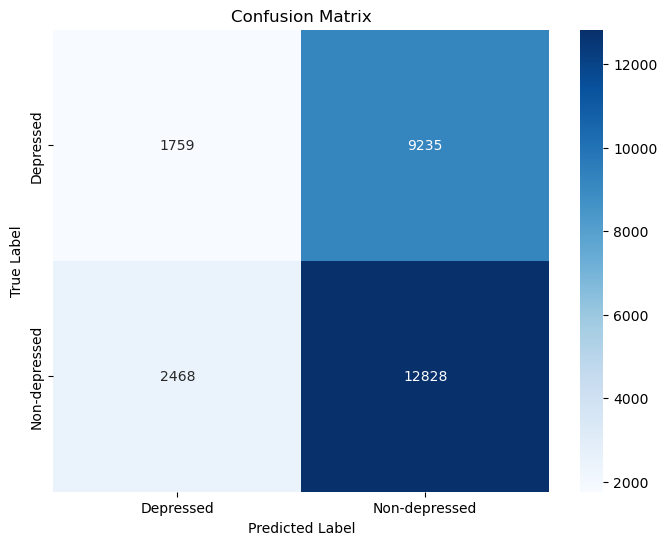

In [38]:
# Calculate the confusion matrix for the combined data
combined_cm = confusion_matrix(lrcombined_true_labels, lrcombined_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(combined_cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=['Depressed', 'Non-depressed'],
            yticklabels=['Depressed', 'Non-depressed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



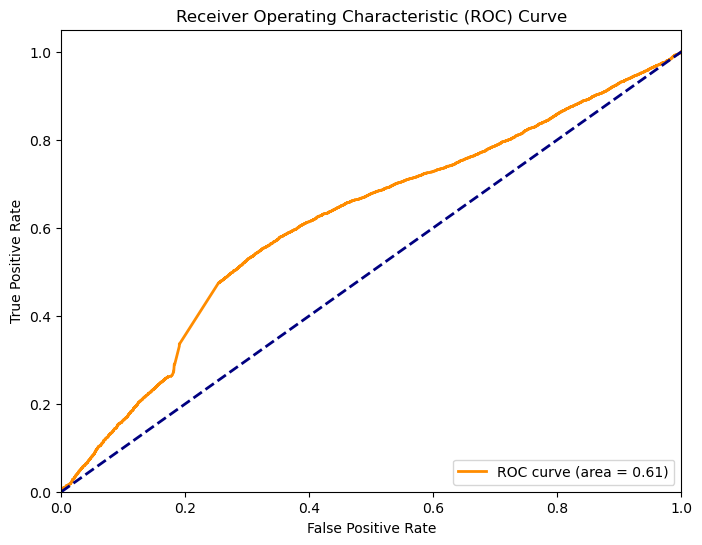

In [39]:
# For the ROC curve:

# After the loop, combine all X_test data
combined_X_test = pd.concat(combined_X_test_list)

# Compute the predicted probabilities using the Random Forest classifier
combined_predicted_probs = lr_best.predict_proba(combined_X_test)[:, 1]

# Compute ROC curve and ROC area for the combined data
fpr, tpr, _ = roc_curve(lrcombined_true_labels, combined_predicted_probs, pos_label='nondepressed')
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()